In [1]:
import numpy as np
import torch
import cv2
import os
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from functions.config import get_config
from functions.models.pose_hrnet import PoseHighResolutionNet

vid_path = 'files\\videos'
img_path = 'files\\images'
dataset_dir = 'finetune_dataset'
CTX = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
box_model = fasterrcnn_resnet50_fpn(pretrained=True)
box_model.to(CTX)
box_model.eval()

# initializing model
cfg = get_config(weights_path='pose_hrnet_w32_384x288.pth')
pose_model = PoseHighResolutionNet(cfg)
pose_model.init_weights(cfg.MODEL.PRETRAINED)
pose_model.to(CTX)
pose_model.eval()
vid_filepath = os.path.join(vid_path, os.listdir(vid_path)[1])

c:\Users\Tijn\Documents\VSC\poses\Huggingface_poses\hf_pose\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tijn\Documents\VSC\poses\Huggingface_poses\hf_pose\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total frames in video: 1406
Processed frame 0.0/141.0
Processed frame 10.0/141.0
Processed frame 20.0/141.0
Processed frame 30.0/141.0
Processed frame 40.0/141.0
Processed frame 50.0/141.0
Processed frame 60.0/141.0
Processed frame 70.0/141.0
Processed frame 80.0/141.0
Processed frame 90.0/141.0
Processed frame 100.0/141.0
Processed frame 110.0/141.0
Processed frame 120.0/141.0
Processed frame 130.0/141.0
Processed frame 140.0/141.0
Processed frame 141.0/141.0


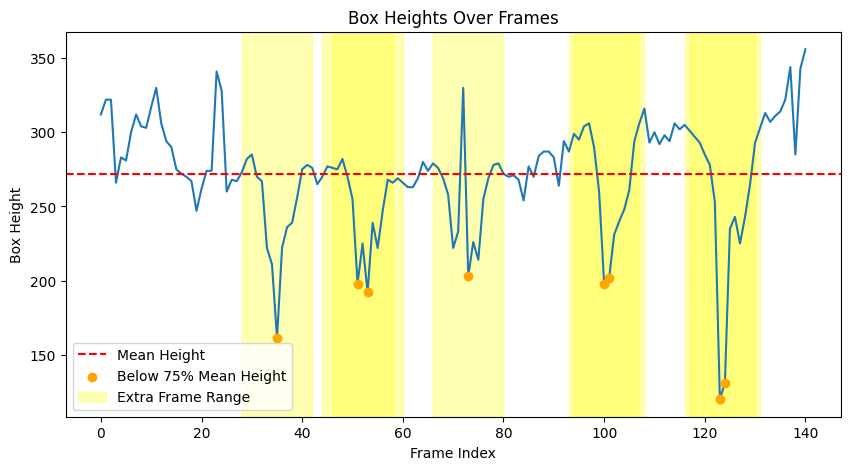

In [2]:
from functions.processing.boxes import retrieve_reps, analyze_boxes
from functions.visualization import visualize_reps
boxes, divisor, total_frames = analyze_boxes(vid_filepath, box_model)
boxes_new, indices, divisor, total_frames = retrieve_reps(boxes, divisor, total_frames)
visualize_reps(boxes, divisor, total_frames)

In [3]:
from functions.processing.keypoints import get_start_end_indices, get_squat_reps, get_even_indices
half_frames = False
squat_reps = get_squat_reps(indices, boxes_new, vid_filepath, box_model, pose_model, half_frames=half_frames)
start, end = get_start_end_indices(indices)
even_indices = get_even_indices(start, end)
    

Total frames in video: 1406
Processed frame 1/1406
Processed frame 11/1406
Processed frame 21/1406
Processed frame 31/1406
Processed frame 41/1406
Processed frame 51/1406
Processed frame 61/1406
Processed frame 71/1406
Processed frame 81/1406
Processed frame 91/1406
Processed frame 101/1406
Processed frame 111/1406
Processed frame 121/1406
Processed frame 131/1406
Processed frame 141/1406
Processed frame 151/1406
Processed frame 161/1406
Processed frame 171/1406
Processed frame 181/1406
Processed frame 191/1406
Processed frame 201/1406
Processed frame 211/1406
Processed frame 221/1406
Processed frame 231/1406
Processed frame 241/1406
Processed frame 251/1406
Processed frame 261/1406
Processed frame 271/1406
Processed frame 281/1406
Processed frame 291/1406
Processed frame 301/1406
Processed frame 311/1406
Processed frame 321/1406
Processed frame 331/1406
Processed frame 341/1406
Processed frame 351/1406
Processed frame 361/1406
Processed frame 371/1406
Processed frame 381/1406
Processe

In [ ]:
import glob
from functions.models.hot_mixste import Model
from functions.processing.pose3d import create_adaptive_args, camera_to_world, normalize_screen_coordinates, pad_sequence_to_length
from functions.visualization import show2Dpose, show3Dpose, showimage
from tqdm import tqdm
import copy
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

vidfile = os.listdir(vid_path)[1]
args = create_adaptive_args()
fix_z = True
output_dir = 'results/' + vidfile.split('.')[0] + '/'
vid_filepath = os.path.join(vid_path, vidfile)
hotmodel = Model(args)
hotmodel.to(CTX)

model_dict = hotmodel.state_dict()
model_path = sorted(glob.glob(os.path.join(args.checkpoint, '*.pth')))[0]
pre_dict = torch.load(model_path)
model_dict = hotmodel.state_dict()
state_dict = {k: v for k, v in pre_dict.items() if k in model_dict.keys()}
model_dict.update(state_dict)
hotmodel.load_state_dict(model_dict)

hotmodel.eval()

cap = cv2.VideoCapture(vid_filepath)
video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_index = 0
for rep in squat_reps.keys():
    print('\nProcessing rep: ' + str(rep) + ' / ' + str(len(squat_reps.keys())))
    # make directories
    output_dir_2D = output_dir + 'rep_' + str(rep) + '/pose2D/'
    os.makedirs(output_dir_2D, exist_ok=True)
    output_dir_3D = output_dir + 'rep_' + str(rep) + '/pose3D/'
    os.makedirs(output_dir_3D, exist_ok=True)
    os.makedirs(output_dir + 'rep_' + str(rep) + '/' + 'output_3D/', exist_ok=True)

    keypoints = np.array(squat_reps[rep]['Keypoints'])
    rep_length = keypoints.shape[0]
    ret, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = args.image_size
    img = cv2.resize(img, (img_size[0], img_size[1]))
    print('\nGenerating 3D pose...')
    frame_sum = 0
    input_2D_no = keypoints.copy()

    joints_left =  [4, 5, 6, 11, 12, 13]
    joints_right = [1, 2, 3, 14, 15, 16]

    input_2D = normalize_screen_coordinates(input_2D_no, w=img_size[0], h=img_size[1])  
    input_2D_aug = copy.deepcopy(input_2D)
    input_2D_aug[ :, :, 0] *= -1
    input_2D_aug[ :, joints_left + joints_right] = input_2D_aug[ :, joints_right + joints_left]
    input_2D = np.concatenate((np.expand_dims(input_2D, axis=0), np.expand_dims(input_2D_aug, axis=0)), 0)    
    input_2D = input_2D[np.newaxis, :, :, :, :]
    input_2D = torch.from_numpy(input_2D.astype('float32')).cuda()
    
    input_2D = pad_sequence_to_length(input_2D, target_length=243)
    N = input_2D.size(0)

    ## estimation
    with torch.no_grad():
        output_3D_non_flip = hotmodel(input_2D[:, 0])
        output_3D_flip     = hotmodel(input_2D[:, 1])

    output_3D_flip[:, :, :, 0] *= -1
    output_3D_flip[:, :, joints_left + joints_right, :] = output_3D_flip[:, :, joints_right + joints_left, :] 

    output_3D = (output_3D_non_flip + output_3D_flip) / 2

    output_3D[:, :, 0, :] = 0
    post_out = output_3D[0].cpu().detach().numpy()
    output_3D_all = post_out.copy()
    rot =  [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088]
    rot = np.array(rot, dtype='float32')
    post_out = camera_to_world(post_out, R=rot, t=0)
    if frame_index == 0:
        for i in range(0, start[0]):
            ret, img = cap.read()
        frame_index = start[0]
    while frame_index < start[rep-1]:
        frame_index += 1
        ret, img = cap.read()
    while frame_index < end[rep-1]:
        ret, img = cap.read()
        if half_frames and frame_index % 2 == 0:
            frame_index += 1
            continue
        print('Processing frame: ' + str(frame_index))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size[0], img_size[1]))
        if half_frames:
            image = show2Dpose(input_2D_no[(frame_index - start[rep-1])//2], copy.deepcopy(img))
        else:
            image = show2Dpose(input_2D_no[frame_index - start[rep-1]], copy.deepcopy(img))
        cv2.imwrite(output_dir_2D + str(('%04d'% (frame_index - start[rep-1]))) + '_2D.png', image)
        frame_index += 1

        ## 3D
        fig = plt.figure(figsize=(9.6, 5.4))
        gs = gridspec.GridSpec(1, 1)
        gs.update(wspace=-0.00, hspace=0.05) 
        ax = plt.subplot(gs[0], projection='3d')
        post_out = output_3D_all[frame_index - start[rep-1]]
        show3Dpose(post_out, ax, fix_z)
        plt.savefig(output_dir_3D + str(('%04d'% (frame_index - start[rep-1]))) + '_3D.png', dpi=200, format='png', bbox_inches = 'tight')
        plt.close(fig)

    ## save 3D keypoints
    output_npz = output_dir + 'rep_' + str(rep)  + '/output_3D/' + 'output_3D.npz'
    np.savez_compressed(output_npz, reconstruction=output_3D_all)

    print('Generating 3D pose successfully!')

    ## all
    image_dir = 'results/' 
    image_2d_dir = sorted(glob.glob(os.path.join(output_dir_2D, '*.png')))
    image_3d_dir = sorted(glob.glob(os.path.join(output_dir_3D, '*.png')))

    print('\nGenerating demo...')
    for i in tqdm(range(len(image_3d_dir))):
        image_3d = plt.imread(image_3d_dir[i])

        edge = 0
        image_3d = image_3d[edge:image_3d.shape[0] - edge, edge:image_3d.shape[1] - edge]
        image_2d = plt.imread(image_2d_dir[i])
        ## show
        font_size = 12
        fig = plt.figure(figsize=(9.6, 5.4))
        ax = plt.subplot(121)
        showimage(ax, image_2d)
        ax.set_title("Input", fontsize = font_size)

        ax = plt.subplot(122)
        showimage(ax, image_3d)
        ax.set_title("Reconstruction", fontsize = font_size)

        ## save
        output_dir_pose = output_dir + 'rep_' + str(rep) + '/pose/'
        os.makedirs(output_dir_pose, exist_ok=True)
        plt.savefig(output_dir_pose + str(('%04d'% i)) + '_pose.png', dpi=200, bbox_inches = 'tight')
        plt.close()


Processing rep: 1 / 5

Generating 3D pose...
Processing frame: 280
Processing frame: 281
Processing frame: 282
Processing frame: 283
Processing frame: 284
Processing frame: 285
Processing frame: 286
Processing frame: 287
Processing frame: 288
Processing frame: 289
Processing frame: 290
Processing frame: 291
Processing frame: 292
Processing frame: 293
Processing frame: 294
Processing frame: 295
Processing frame: 296
Processing frame: 297
Processing frame: 298
Processing frame: 299
Processing frame: 300
Processing frame: 301
Processing frame: 302
Processing frame: 303
Processing frame: 304
Processing frame: 305
Processing frame: 306
Processing frame: 307
Processing frame: 308
Processing frame: 309
Processing frame: 310
Processing frame: 311
Processing frame: 312
Processing frame: 313
Processing frame: 314
Processing frame: 315
Processing frame: 316
Processing frame: 317
Processing frame: 318
Processing frame: 319
Processing frame: 320
Processing frame: 321
Processing frame: 322
Processi

 42%|████▏     | 62/149 [00:30<00:40,  2.13it/s]

In [6]:
# turn images into video
import cv2
def images_to_video(image_folder, video_name, fps=30):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort()  # Ensure the images are sorted
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
# Create video for each rep
for rep in squat_reps.keys():
    output_dir_pose = output_dir + 'rep_' + str(rep) + '/pose/'
    video_name = output_dir + 'rep_' + str(rep) + '/output.mp4'
    images_to_video(output_dir_pose, video_name, fps=30)
    print(f"Video for rep {rep} saved as {video_name}")

Video for rep 1 saved as results/VID_20211224_120346353 - Trim/rep_1/output.mp4
Video for rep 2 saved as results/VID_20211224_120346353 - Trim/rep_2/output.mp4
Video for rep 3 saved as results/VID_20211224_120346353 - Trim/rep_3/output.mp4
Video for rep 4 saved as results/VID_20211224_120346353 - Trim/rep_4/output.mp4
Video for rep 5 saved as results/VID_20211224_120346353 - Trim/rep_5/output.mp4


In [ ]:
skeleton = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13], [6,7],[6,8],
        [7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
skel = [[coord-1 for coord in pair] for pair in skeleton]


In [ ]:
import matplotlib.pyplot as plt
skeleton = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13], [6,7],[6,8],
        [7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
skel = [[coord-1 for coord in pair] for pair in skeleton]
def plot_3d_keypoints_with_skeleton(keypoints, skeleton, frame_index=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each joint
    for joint in keypoints[frame_index]:
        ax.scatter(joint[0], joint[1], joint[2], marker='o')
    
    # Plot skeleton
    for pair in skeleton:
        joint1 = keypoints[frame_index][pair[0]]
        joint2 = keypoints[frame_index][pair[1]]
        ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], [joint1[2], joint2[2]], 'r-')
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D Keypoints with Skeleton - Frame {frame_index}')
    
    plt.show()
# Example usage
for frame_index in range(0, len(output_3d_all), 10):  # Adjust step for fewer frames
    plot_3d_keypoints_with_skeleton(output_3d_all, skel, frame_index)

1. Folders of videos :)
2. do random sampling on all videos, if confidence abysmally low or bbox unfindable, bin video as too low quality
3. Pick single video :)
4. Preprocess into separate frames :)
5. Calculate bbox for every frame :)
6. Decide if BBOX is recognizable in video -> bin videos where bbox is not found for at least 10% (?) of frames :)
7. Calculate HRNET for first 15 frames -> if confidence < 0.5 bin the video
8. Calculate HRNET for all frames
9. Run 3d pose estimation of all frames
10. Retrieve 3d frame position of lower body joints
11. Observe changes in joints